# Предсказание объема оборота в магазинах компании Rossman

<img src='../../img/rossman_logo.png'>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы

## Часть 1. Описание набора данных и признаков

[Данные](https://www.kaggle.com/c/rossmann-store-sales) представляют собой информацию об объеме оборота в 1115 магазинах компании Rossman в Германии в зависимости от предоставленных признаков. Ассортимент представлен от бытовой химии и детских принадлежностей до косметики. Раньше менеджеры магазинов сами предсказывали число продаж основываясь на собственном мнении. Вследствие чего разброс предсказанных значений был высоким.

Решается задача регрессии. Она состоит в том, чтобы наиболее точно предсказать число продаж определнного магазина в определенный день. Предсказание меньшего числа, ровно как и большего может привести к убыткам.

Данные представлены во временном промежутке от 1 января 2013 года до 31 июля 2015 года. Также стоит отметить, что есть временной признак, значимость которого еще следует установить.

Источником данных служит соревнование на Kaggle.

### Переменные

#### Общая информация о магазине

1. Id - ID, который идентифицирует магазин и дату.
2. Store - ID, который присвоен каждому магазину.
3. Customers - число клиентов. (в тесте отстутствует)
4. Open - некоторые магазины могли быть закрыты на ремнот. Идентифицирует открыт ли сейчас магазин: 0 = закрыт, 1 = открыт.
5. StoreType - магазины представлены четырьмя видами: a, b, c, d. Дополнительной информации не дано.
6. Assortment - уровень ассортимента: a = basic, b = extra, c = extended.

#### Информация о выходных днях

1. StateHoliday - является ли представленный день выходным. Обычно магазины в выходные не работают. Также все школы закрыты во время любых выходных. a = общий выходной, b = Пасха, c = Рождество, 0 = Нет
2. SchoolHoliday - отражает было ли наблюдение подвержено наличию школьных выходных (0, 1). Очевидно, что наличие влияния автоматичесеки приводит к наличию самих школьных выходных.

#### Наличие конкурентов поблизости

1. CompetitionDistance - расстояние до ближайшего конкурента.
2. CompetitionOpenSince[Month/Year] - дата открытия конкурента. Видимо, NaN значит, что конкурент был открыт позже представленного магазина.

#### Промоакции индивидуальные для каждого магазина и, в некторых случаях, дня

1. Promo - проводит ли магазин акцию.
2. Promo2 - некторые магазины участвуют в прродлжительной и периодичной акции: 0 = не участвует, 1 = участвует
3. Promo2Since[Year/Week] - когда магазин начал принимать участие в акции Promo2.
4. PromoInterval - задает интервалы перезапуска акции Promo2. Например, "Feb,May,Aug,Nov" значи, что акция перезапускается в Феврале, Мае, Августе и Ноябре каждый год.

#### Временная шкала

1. Date: дата наблюдения
2. DayOfWeek: день недели

#### Целевая переменная

1. Sales - оборот данного магазина в данный день. Это значение будет предсказываться.

Также признаки можно разделить на две группы так же, как они разделены на два файла train.csv и store.csv:
1. Зависят от времени: 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday'.
2. Зависят только от локации: 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from scipy.stats import normaltest, skewtest, skew
from scipy.sparse import csr_matrix, hstack
%matplotlib inline
pd.set_option('max_columns', 100)

## Часть 2. Первичный анализ признаков

Считаем данные.

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
test = pd.read_csv('data/test.csv')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [4]:
stores = pd.read_csv('data/store.csv')
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
print(train.info(), "\n")
print(test.info(), "\n")
print(stores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage

Можно заметить, что признак Open в тестовом датасете типа float.

Для дальнейшего удобства визуализации сконвертируем некоторые признаки из типа object в тип int. Данные числа не будут иметь ничего общего со значениями этих признаков. В дальнейшем к ним нужно будет применить более осмысленную предобработку.

In [6]:
letters_to_ints = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
stores['StoreType'] = stores['StoreType'].map(letters_to_ints)
stores['Assortment'] = stores['Assortment'].map(letters_to_ints)

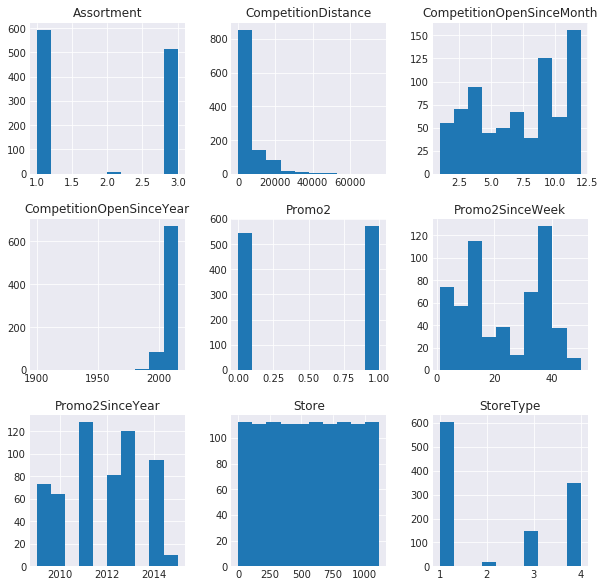

In [7]:
stores.hist(figsize=(10, 10));

Взглянем подробнее на наиболее интресные графики.

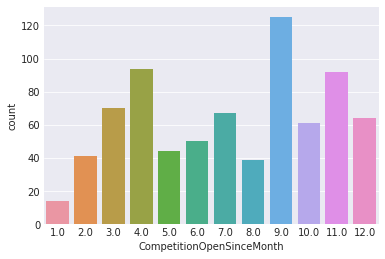

In [8]:
sns.countplot(stores['CompetitionOpenSinceMonth']);

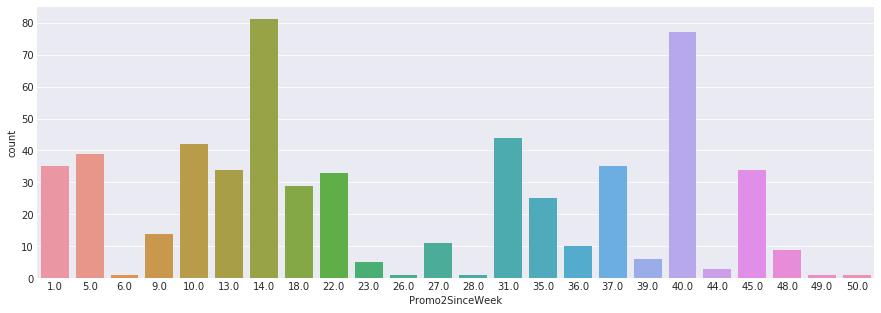

In [9]:
plt.figure(figsize=(15, 5))
sns.countplot(stores['Promo2SinceWeek']);

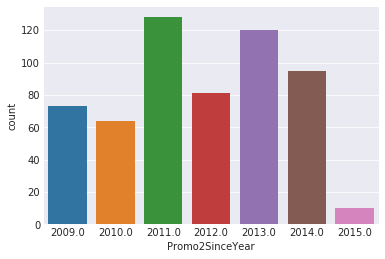

In [10]:
sns.countplot(stores['Promo2SinceYear']);

Видны пики и падения в определенное время года. Возможно есть периодичность, но пока этого заключить нельзя. Может они как-то связаны с целевой перменной? Это подробнее рассмторим позже, когда объединим таблицы.

Посмотрим на зависимость между ассортиментом и типом магазина.

In [11]:
pd.crosstab(stores['Assortment'], stores['StoreType'], margins=True)

StoreType,1,2,3,4,All
Assortment,,,,,
1,381,7,77,128,593
2,0,9,0,0,9
3,221,1,71,220,513
All,602,17,148,348,1115


Видно, что из значения Assortment 'extra' следует второй тип магазина. Также стандартный ассортимент чаще встречается в магазинах первого типа, а расширенный в магазинах четвертого типа.

Напоследок посмотрим на признак PromoInterval. Он чистый и заполнен по образцу. С ним будет удобно работать.

In [12]:
stores['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

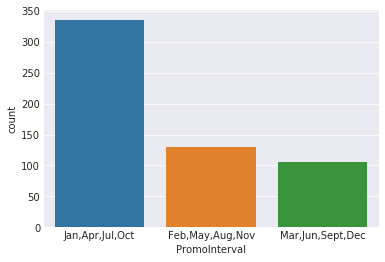

In [13]:
sns.countplot(stores['PromoInterval']);

Чаще всего магазины пользовались схемой "Январь, Апрель, Июль, Октябрь".

Объединим таблицы, так как предсказывать нужно для наблюдений. Каждому наблюдению припишем признаки соответствующего магазина. Также отсортируем наблюдения по времени.

In [14]:
stores_dict = {}
stores_dict['StoreType'] = dict(zip(stores.Store, stores.StoreType))
stores_dict['Assortment'] = dict(zip(stores.Store, stores.Assortment))
stores_dict['CompetitionDistance'] = dict(zip(stores.Store, stores.CompetitionDistance))
stores_dict['CompetitionOpenSinceMonth'] = dict(zip(stores.Store, stores.CompetitionOpenSinceMonth))
stores_dict['CompetitionOpenSinceYear'] = dict(zip(stores.Store, stores.CompetitionOpenSinceYear))
stores_dict['Promo2'] = dict(zip(stores.Store, stores.Promo2))
stores_dict['Promo2SinceWeek'] = dict(zip(stores.Store, stores.Promo2SinceWeek))
stores_dict['Promo2SinceYear'] = dict(zip(stores.Store, stores.Promo2SinceYear))
stores_dict['PromoInterval'] = dict(zip(stores.Store, stores.PromoInterval))

In [15]:
for col in stores.columns[1:]:
    train[col] = train['Store'].map(stores_dict[col])
train.Date = train.Date.apply(lambda x: pd.Timestamp(x))
train = train.sort_values(['Date'])
                           
for col in stores.columns[1:]:
    test[col] = test['Store'].map(stores_dict[col])
test.Date = test.Date.apply(lambda x: pd.Timestamp(x))

# Также нужно не забыть перевести StateHoliday в значения int. 
# Соображения те же, что и с признаками StoreType и Assortment
train['StateHoliday'] = train['StateHoliday'].map({'0': 0, 0: 0, 'a': 1, 'b': 2, 'c': 3})
test['StateHoliday'] = test['StateHoliday'].map({'0': 0, 0: 0, 'a': 1, 'b': 2, 'c': 3})

Удобнее будет, если целевой признак находится в конце таблицы.   
В дальнейшем будем работать только с этой таблицей.

In [16]:
y = train['Sales']
train = train.drop('Sales', axis=1)
train['Sales'] = y

Изучим пропуски и нулевые значения.

In [17]:
cnt_nans = pd.DataFrame()
cnt_nans['NansCount'] = pd.Series(np.empty(train.shape[1]))
cnt_nans['NansPersentage'] = pd.Series(np.empty(train.shape[1]))
cnt_nans.index = train.columns
for col in train.columns:
    cnt_nans['NansCount'][col] = np.sum(train[col].isna())
    cnt_nans['NansPersentage'][col] = np.sum(train[col].isna()) / train.shape[0]
cnt_nans['NansCount'] = cnt_nans['NansCount'].astype('int')
cnt_nans

,NansCount,NansPersentage
Store,0,0.000000
DayOfWeek,0,0.000000
Date,0,0.000000
Customers,0,0.000000
Open,0,0.000000
Promo,0,0.000000
StateHoliday,0,0.000000
SchoolHoliday,0,0.000000
StoreType,0,0.000000
Assortment,0,0.000000


In [18]:
cnt_nans = pd.DataFrame()
cnt_nans['NansCount'] = pd.Series(np.empty(test.shape[1]))
cnt_nans['NansPersentage'] = pd.Series(np.empty(test.shape[1]))
cnt_nans.index = test.columns
for col in test.columns:
    cnt_nans['NansCount'][col] = np.sum(test[col].isna())
    cnt_nans['NansPersentage'][col] = np.sum(test[col].isna()) / test.shape[0]
cnt_nans['NansCount'] = cnt_nans['NansCount'].astype('int')
cnt_nans

,NansCount,NansPersentage
Id,0,0.000000
Store,0,0.000000
DayOfWeek,0,0.000000
Date,0,0.000000
Open,11,0.000268
Promo,0,0.000000
StateHoliday,0,0.000000
SchoolHoliday,0,0.000000
StoreType,0,0.000000
Assortment,0,0.000000


Видно присутствует немало пропусков в данных, но они соответствуют их природе. То есть, например, нет Promo2 значит нет и даты начала Promo2.

Признак Open имеет 11 значений NaN в тестовом датасете.

In [19]:
cnt_zeros = pd.DataFrame()
cnt_zeros['ZerosCount'] = pd.Series(np.empty(train.shape[1]))
cnt_zeros['ZerosPersentage'] = pd.Series(np.empty(train.shape[1]))
cnt_zeros.index = train.columns
for col in train.columns:
    if (train[col].dtype != 'int'):
        continue
    cnt_zeros['ZerosCount'][col] = np.sum(train[col] == 0)
    cnt_zeros['ZerosPersentage'][col] = np.sum(train[col] == 0) / train.shape[0]
cnt_zeros['ZerosCount'] = cnt_zeros['ZerosCount'].astype('int')
cnt_zeros

,ZerosCount,ZerosPersentage
Store,0,0.000000e+00
DayOfWeek,0,0.000000e+00
Date,0,7.410985e-323
Customers,172869,1.699444e-01
Open,172817,1.698933e-01
Promo,629129,6.184855e-01
StateHoliday,986159,9.694753e-01
SchoolHoliday,835488,8.213533e-01
StoreType,0,0.000000e+00
Assortment,0,0.000000e+00


В данных есть очень много нулей, но нужно вспомнить, что тип _a_ заменялся на 0, а также есть бинарные признаки, значения 0 для которых вполне естественны. Более интересны нулевые значения целевой переменной и признаков Customers и Open. Они почти совпадают и отражают логику происходящего: если магазин закрыт, значит нет и клиентов, и оброта.   

In [20]:
# Проверим это
train['Sales'][(train['Open'] == 0)].max(), train['Sales'][(train['Open'] == 0)].shape[0]

(0, 172817)

Но откуда остальные нули? Посмотрим позже.

Open имеет тип float. Заменим NaN на 1. Из того, что выше следует, что из тренировочного датасета можно выкинуть все записи с закрытыми магазинами. Если мы заменим NaN на 0, то можем и не попасть в правильное значение, а заменив на 1 предскажем какое-то значение ближе к правде.

In [21]:
test['Open'].fillna(1, inplace=True)
test['Open'] = test['Open'].astype('int')

In [22]:
cnt_zeros = pd.DataFrame()
cnt_zeros['ZerosCount'] = pd.Series(np.empty(test.shape[1]))
cnt_zeros['ZerosPersentage'] = pd.Series(np.empty(test.shape[1]))
cnt_zeros.index = test.columns
for col in test.columns:
    if (test[col].dtype != 'int'):
        continue
    cnt_zeros['ZerosCount'][col] = np.sum(test[col] == 0)
    cnt_zeros['ZerosPersentage'][col] = np.sum(test[col] == 0) / test.shape[0]
cnt_zeros['ZerosCount'] = cnt_zeros['ZerosCount'].astype('int')
cnt_zeros

,ZerosCount,ZerosPersentage
Id,0,0.000000e+00
Store,0,0.000000e+00
DayOfWeek,0,0.000000e+00
Date,0,5.434722e-323
Open,5984,1.456386e-01
Promo,24824,6.041667e-01
StateHoliday,40908,9.956192e-01
SchoolHoliday,22866,5.565129e-01
StoreType,0,0.000000e+00
Assortment,0,0.000000e+00


Ничем от тренировочного датасета не отличается.

describe не сильно помогает, но можно бегом взглянуть на средние значения и стандартные отклонения. Остальное лучше на графиках смотреть.

In [23]:
train.describe()

,Store,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.014567e+06,693861.000000,693861.000000,1.017209e+06,509178.000000,509178.000000,1.017209e+06
mean,5.584297e+02,3.998341e+00,6.331459e+02,8.301067e-01,3.815145e-01,4.516279e-02,1.786467e-01,2.207467e+00,1.935141e+00,5.430086e+03,7.222866,2008.690228,5.005638e-01,23.269093,2011.752774,5.773819e+03
std,3.219087e+02,1.997391e+00,4.644117e+02,3.755392e-01,4.857586e-01,2.836559e-01,3.830564e-01,1.365376e+00,9.938011e-01,7.715324e+03,3.211832,5.992644,4.999999e-01,14.095973,1.662870,3.849926e+03
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+01,1.000000,1900.000000,0.000000e+00,1.000000,2009.000000,0.000000e+00
25%,2.800000e+02,2.000000e+00,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,7.100000e+02,4.000000,2006.000000,0.000000e+00,13.000000,2011.000000,3.727000e+03
50%,5.580000e+02,4.000000e+00,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.330000e+03,8.000000,2010.000000,1.000000e+00,22.000000,2012.000000,5.744000e+03
75%,8.380000e+02,6.000000e+00,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,3.000000e+00,6.890000e+03,10.000000,2013.000000,1.000000e+00,37.000000,2013.000000,7.856000e+03
max,1.115000e+03,7.000000e+00,7.388000e+03,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00,3.000000e+00,7.586000e+04,12.000000,2015.000000,1.000000e+00,50.000000,2015.000000,4.155100e+04


In [24]:
test.describe()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,40992.000000,25872.000000,25872.000000,41088.000000,23856.000000,23856.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.004381,0.443487,2.252336,2.001168,5088.583138,7.035250,2008.641929,0.580607,24.426559,2011.820926
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.066044,0.496802,1.397401,0.994741,7225.487467,3.143015,6.862400,0.493466,14.161312,1.692166
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,720.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,2425.000000,7.000000,2010.000000,1.000000,22.000000,2012.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,0.000000,1.000000,4.000000,3.000000,6480.000000,9.000000,2012.000000,1.000000,37.000000,2013.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,1.000000,4.000000,3.000000,75860.000000,12.000000,2015.000000,1.000000,49.000000,2015.000000


Посмотрим на гистограммы.

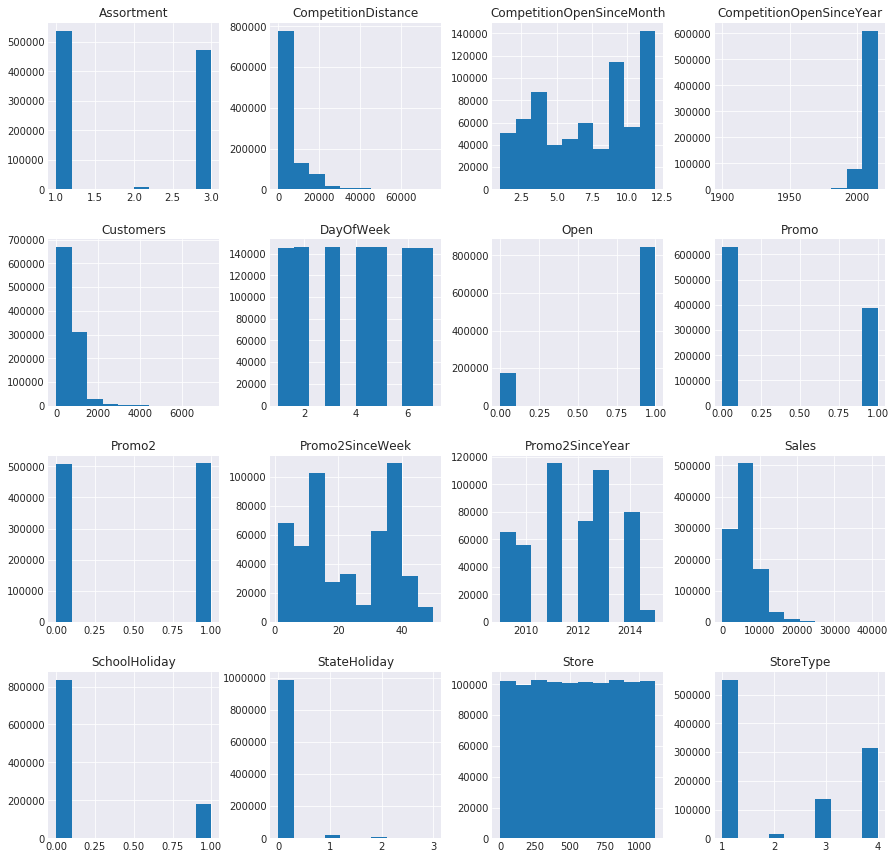

In [25]:
train.hist(figsize=(15, 15));

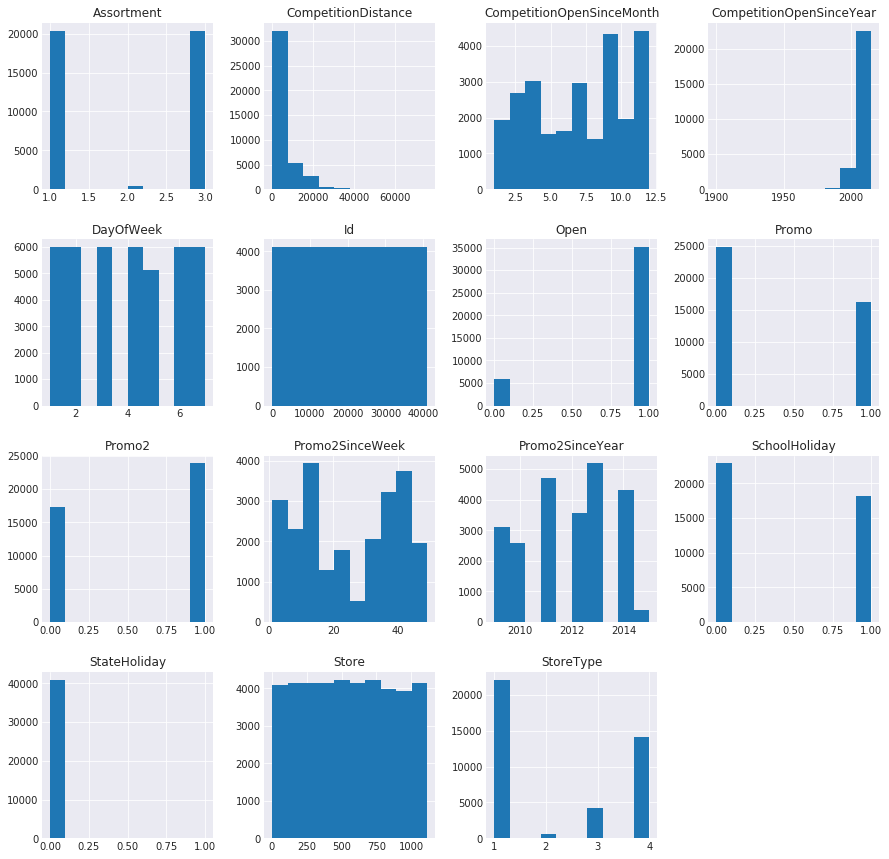

In [26]:
test.hist(figsize=(15, 15));

Многие из этих графиков уже были нарисованы при рассмотре таблицы store. Только сейчас изображено распределение числа наблюдений. Это, однако, не сильно меняет картину. Какие-то немного сгладились, а какие-то немного выделились.

Есть только один интересный момент. В тесте нет наблюдений во время Рождества и Пасхи

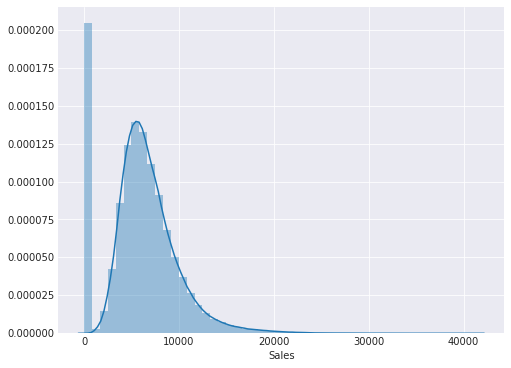

In [27]:
plt.figure(figsize=(8, 6))
sns.distplot(train['Sales']);

In [28]:
normaltest(train['Sales'])

NormaltestResult(statistic=99895.45232064847, pvalue=0.0)

In [29]:
skew(train['Sales'])

0.6414586698987548

In [30]:
skewtest(train['Sales'])

SkewtestResult(statistic=242.52993972899088, pvalue=0.0)

normaltest отвергает гипотезу о нормальности распределения. Тест на скошенность говорит, что правый хвост имеет больший вес, что впрочем и видно на графике. Это может ухудшить качество линейной модели. Поэтому попробуем прологарифмировать. Также уберем нулевые значения, так как понятно откуда они появляются.

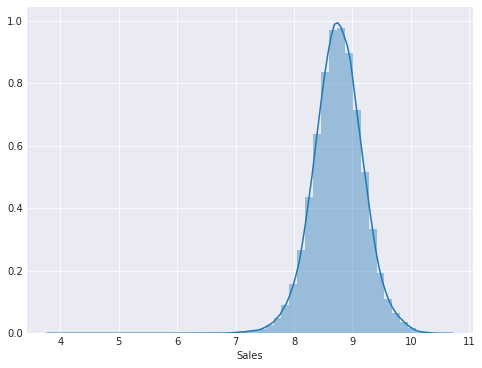

In [31]:
plt.figure(figsize=(8, 6))
sns.distplot(np.log1p(train['Sales'][(train['Sales'] != 0)]));

In [32]:
normaltest(np.log1p(train['Sales'][(train['Sales'] != 0)]))

NormaltestResult(statistic=10404.06476317289, pvalue=0.0)

In [33]:
skew(np.log1p(np.log1p(train['Sales'][(train['Sales'] != 0)])))

-0.2907315655890412

In [34]:
skewtest(np.log1p(train['Sales'][(train['Sales'] != 0)]))

SkewtestResult(statistic=-40.89061275873305, pvalue=0.0)

Явно стало лучше.

In [35]:
pd.crosstab(train['StateHoliday'], train['SchoolHoliday'], margins=True)

SchoolHoliday,0,1,All
StateHoliday,,,
0,819949,166210,986159
1,15055,5205,20260
2,484,6206,6690
3,0,4100,4100
All,835488,181721,1017209


По первой строчке становится ясно, что SchoolHoliday подразумевает еще и каникулы.  
Во время рождества все наблюдения подвергались действию школьных выходных(каникул). Видимо это особенность собранных данных.

In [36]:
pd.crosstab(test['StateHoliday'], test['SchoolHoliday'], margins=True)

SchoolHoliday,0,1,All
StateHoliday,,,
0,22686,18222,40908
1,180,0,180
All,22866,18222,41088


В трейне выходных первого типа и одновременно оказавших вляние школьных выходных в три раза меньше чем таких же выходных, не оказывавших влияние, в тесте их вообще нет.

Следует взглянуть на корреляции числовых признаков.

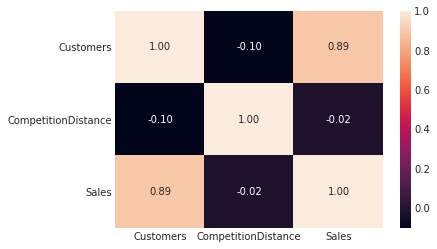

In [37]:
corr_cols = ['Customers', 'CompetitionDistance', 'Sales']
sns.heatmap(train[corr_cols].dropna().corr(), annot=True, fmt = ".2f");

### Кратко, что привлекает внимание

* Promo2SinceWeek имеет два больших периода с относительно высоким числом наблюдений.
* Примерно половина магазинов имеют стандартный формат или стандартный ассортимент. Магазинов между расширенным ассортиментом и стандартным очень мало.
* В датасете много пропусков, но большинство из них логичные.
* Целевой признак очень сильно коррелирует с признаком Customers, что естественно. Только это зачение при предсказании мы знать не будем.
* Явно видна связь между закрытостью магазина и числом клиентов, объемом продаж.
* При использовании линейной модели таргет стоит прологарифмировать.

## Часть 3. Первичный визуальный анализ признаков

In [38]:
def get_grouped_bar(features, figsize=None, train=train):
    """Строит средние таргета по какому-то, чаще категориальному, признаку в виде столбцов.
    
    Parameters
    ----------
    features: list string'ов
        Названия признаков для визуализации.
    figsize: tuple, 2 числа
        Размеры графиков.
    train: pd.DataFrame, default global
        Датасет для визуализации. Должны присутствовать признаки features.
    """
    _, axes = plt.subplots(len(features) // 3 + (len(features) % 3 > 0), min(3, len(features)), 
                           sharey=True, figsize=figsize)
    
    try:
        axes = axes.reshape(-1)
    except:
        axes = [axes]
    
    for ind, feature in enumerate(features):
        gr = train.groupby(feature)
        xx = gr.groups.keys()
        yy = gr['Sales'].mean()

        df = pd.DataFrame()
        df['SalesMean'] = yy
        df[feature] = xx

        sns.barplot(feature, 'SalesMean', data=df, ax=axes[ind])

### Численные и временные признаки

Так как была выявлена высокая корреляция между целевым признаком и признаком Customers, посмотрим на график их взаимного распределения.

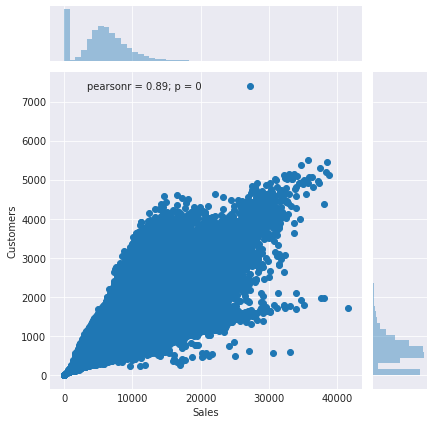

In [39]:
sns.jointplot(x='Sales', y='Customers', data=train);

Прослеживается линейная зависимость, что впрочем соответствует природе данных. Также видно, что разброс относительно среднего значения большой, но у него странная форма: сначала как и положено разброс постепенно увеличивается, а потом достаточно резко уменьшается.

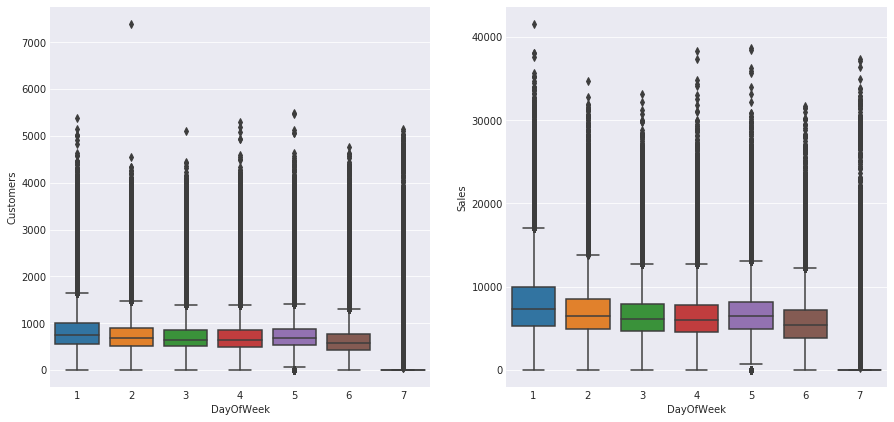

In [40]:
_, axes = plt.subplots(1, 2, figsize=(15, 7))
sns.boxplot(x='DayOfWeek', y='Customers', data=train, ax=axes[0]);
sns.boxplot(x='DayOfWeek', y='Sales', data=train, ax=axes[1]);

Вот и еще одно полезное наблюдение. В последний день клиентов нет. В выходные магазины не работают. Не то, чтобы совсем, но по крайне мере большинство.

Вот и узнаем от чего это зависит.

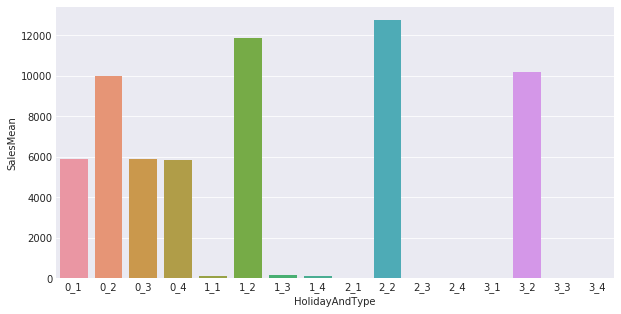

In [41]:
train['HolidayAndType'] = train['StateHoliday'].apply(lambda x: str(x)) + '_' + \
    train['StoreType'].apply(lambda x: str(x))
get_grouped_bar(['HolidayAndType'], (10, 5))

In [42]:
np.sum(train[train['StateHoliday'].isin([2, 3]) & (train['StoreType'] != 2)]['Sales'] > 0) # Проверим увиденное
# Масштаб обманывает

50

In [43]:
train.drop('HolidayAndType', axis=1, inplace=True)

Очень интересный график! Видно, что во время Рождесства и Пасхи все магазины кроме второго типа не работают совсем(хотелось бы так положить, но, как видим, это не совсем верно). А также в этих магазинах есть что-то особенное, что они не только во время праздников имеют высокий оборот, но и в рабочее время тоже. Интересно, а они вообще могут не работать? (Разумеется по причине отличной от Open == 0)

In [44]:
train[(train['Sales'] == 0) & (train['StoreType'] == 2) & (train['StateHoliday'] == 3) & (train['Open'] == 1)]['Store'].shape[0],\
train[(train['Sales'] == 0) & (train['StoreType'] == 2) & (train['StateHoliday'] == 2) & (train['Open'] == 1)]['Store'].shape[0],\
train[(train['Sales'] == 0) & (train['StoreType'] == 2) & (train['StateHoliday'] == 1) & (train['Open'] == 1)]['Store'].shape[0]

(0, 0, 0)

In [45]:
train[(train['Sales'] == 0) & (train['StoreType'] == 2) & (train['Open'] == 1) & (train['StateHoliday'] == 0)]

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales
975098,259,4,2013-02-07,0,1,1,0,0,2,2,210.0,NaN,NaN,0,NaN,NaN,NaN,0
933937,353,6,2013-03-16,0,1,0,0,0,2,2,900.0,NaN,NaN,1,14.0,2013.0,"Feb,May,Aug,Nov",0
889932,948,4,2013-04-25,5,1,1,0,0,2,2,1430.0,NaN,NaN,0,NaN,NaN,NaN,0


Видимо, нет, а три наблюдения выше скорее всего выбросы.

Заменим пропущенные значения CompetitionDistance достаточно большими числами, чтобы увидеть, как влияет на оборот отсутствие конкурентов.

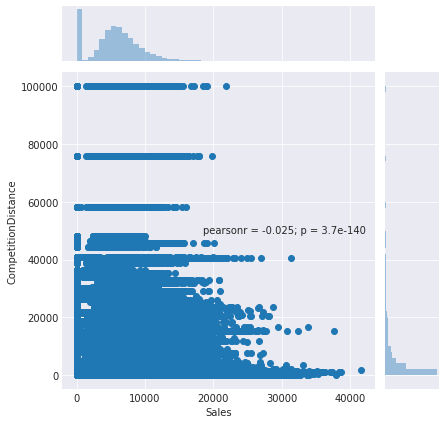

In [46]:
sns.jointplot(x="Sales", y="CompetitionDistance", data=train.fillna(100000));

Магазины с отсутствующей конкуренцией или, что почти одно и то же, с конкурентами расположенными далеко имеют меньший оброт, а в тех случаях, когда конкурирующие магазины расположены близко, оборот выше. Это может показаться странным, но не стоит путать оборот с прибыльностью. Просится мысль, что там, где большее число посетителей, больше оборот, и поэтому конкуренты тоже стараются открывать в таких местах свои магазины.  
Также график немного похож на график дискретной величины. Возможно из-за того, что люди склонны к округлениям.

Создадим для визуализации вспомогательные признаки, связанные со датой наблюдения, которые также могут пригодиться в будущем, и изучим их вляние на целевую переменную.

In [47]:
day = train['Date'].apply(lambda x: x.day)
month = train['Date'].apply(lambda x: x.month)
year = train['Date'].apply(lambda x: x.year)
year_mnth = year * 100 + month
mnths = year * 12 + month - 2013*12
train['Year'] = year
train['MonthsFromStart'] = mnths
train['YearMonth'] = month
train['MonthDay'] = day
train['DaysFromStart'] = (year * 365.5 + month*30.4 + day - 2013 * 365.5).astype('int')

In [48]:
day = test['Date'].apply(lambda x: x.day)
month = test['Date'].apply(lambda x: x.month)
year = test['Date'].apply(lambda x: x.year)
year_mnth = year * 100 + month
mnths = year * 12 + month - 2013*12
test['Year'] = year
test['MonthsFromStart'] = mnths
test['YearMonth'] = month
test['MonthDay'] = day
test['DaysFromStart'] = (year * 365.5 + month*30.4 + day - 2013 * 365.5).astype('int')

Построим графики средних занчений таргета для каждого:
1. Года
2. Месяца с начала наблюдений
3. Месяца в году
4. Дня в месяце
5. Дня с начала наблюдений

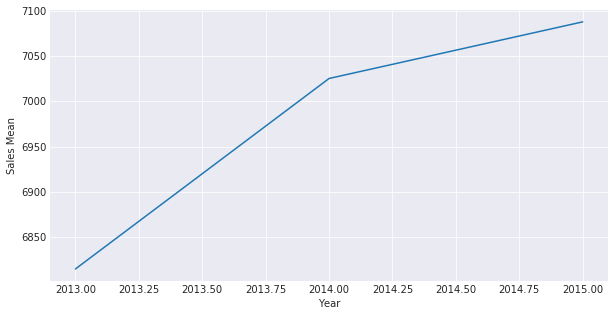

In [49]:
mask_no_zeros = train['Open'] != 0 # Мы знаем, что их можно выбросить. Это сделает графики более гладкими
gr = train[mask_no_zeros].groupby('Year')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(10, 5))
plt.plot(xx, yy);
plt.xlabel("Year");
plt.ylabel("Sales Mean");

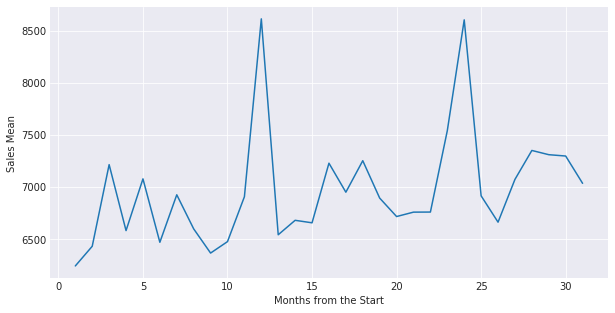

In [50]:
gr = train[mask_no_zeros].groupby('MonthsFromStart')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(10, 5))
plt.plot(xx, yy);
plt.xlabel("Months from the Start");
plt.ylabel("Sales Mean");

Есть два очень высоких значения. Они соответствуют концу года. А что бывает в конце года?  
Правильно, Рождество.

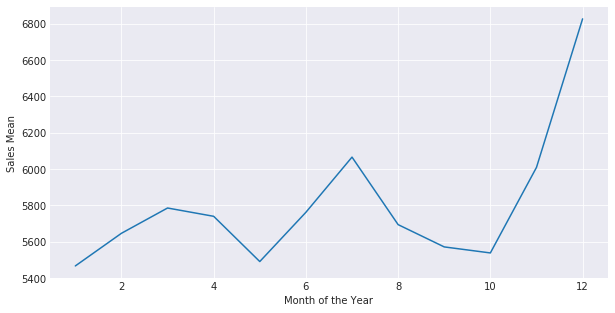

In [51]:
gr = train.groupby('YearMonth')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(10, 5))
plt.plot(xx, yy);
plt.xlabel("Month of the Year");
plt.ylabel("Sales Mean");

Кроме этого есть еще и другие интересные месяцы: третий и седьмой.

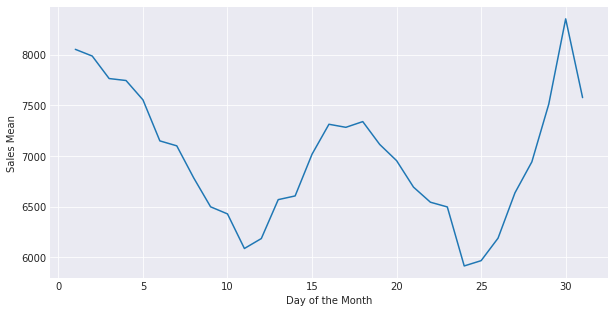

In [52]:
gr = train[mask_no_zeros].groupby('MonthDay')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(10, 5))
plt.plot(xx, yy);
plt.xlabel("Day of the Month");
plt.ylabel("Sales Mean");

В 31ый день начинается падение и оно продолжается до 11 числа следующего месяца. Дальше среднее значение оборота возрастает до примерно 17 числа и падает до 24го. После 24го растет до 30го.

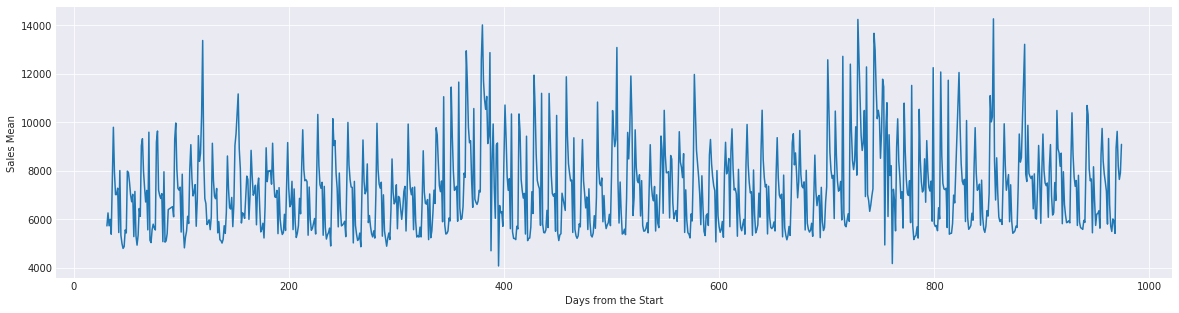

In [53]:
gr = train[mask_no_zeros].groupby('DaysFromStart')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(20, 5))
plt.plot(xx, yy);
plt.xlabel("Days from the Start");
plt.ylabel("Sales Mean");

Добавление признаков отражающих найденные сезоннсти явно может помочь при построении модели.

### Промоакции

Построем график зависимости среднего значения целевой перменной от времени начала акции Promo2.

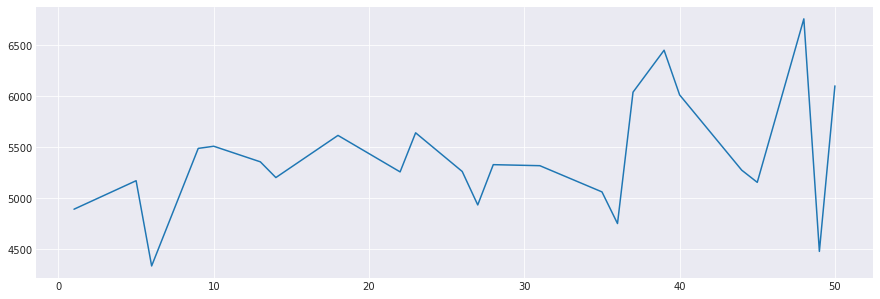

In [54]:
gr = train.groupby('Promo2SinceWeek')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(15, 5))
plt.plot(xx, yy);

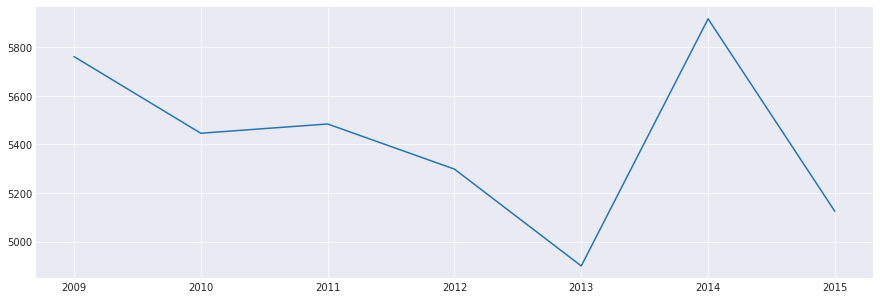

In [55]:
gr = train.groupby('Promo2SinceYear')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(15, 5))
plt.plot(xx, yy);

Видно, что падение среднего значения иногда совпадает с отсутствием стартов Promo2, но пока что сложно установить между этими переменными какую-то связь.

Попробуем визуализировать PromoInterval.

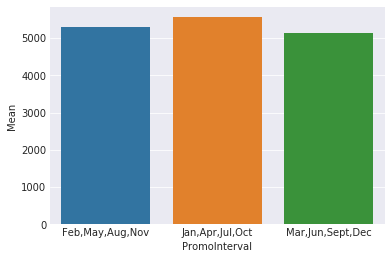

In [56]:
gr = train.groupby('PromoInterval')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

df = pd.DataFrame()
df['Mean'] = yy
df['PromoInterval'] = xx

sns.barplot('PromoInterval', 'Mean', data=df);

Пока что ничего сказать нельзя, но все равно этот признак нужно будет учесть при предобработке. Можно, например, OHE сделать по каждому месяцу.

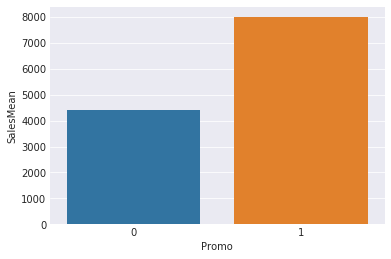

In [57]:
get_grouped_bar(['Promo'])

ВрЕменные промоакции явно помогают повысить оборот.

### Снова о конкуренции

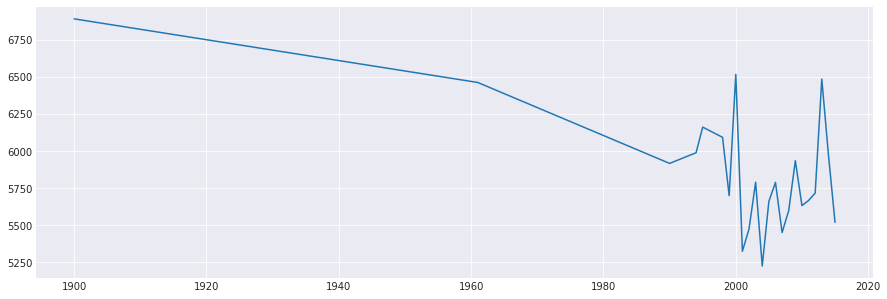

In [58]:
gr = train.groupby('CompetitionOpenSinceYear')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(15, 5))
plt.plot(xx, yy);

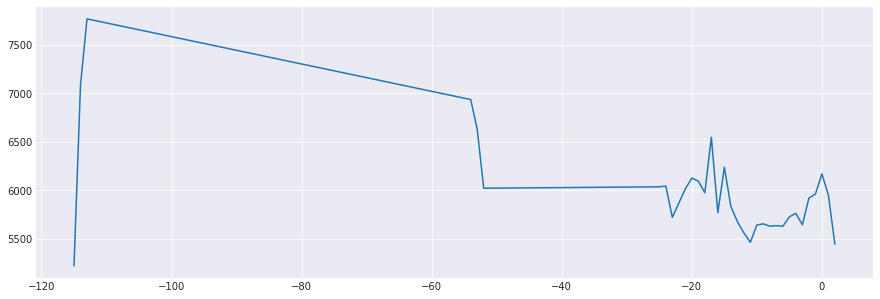

In [59]:
train['TimeFromCompetitionBegin'] = train['CompetitionOpenSinceYear'] - train['Year']
test['TimeFromCompetitionBegin'] = test['CompetitionOpenSinceYear'] - test['Year']

gr = train.groupby('TimeFromCompetitionBegin')
xx = gr.groups.keys()
yy = gr['Sales'].mean()

plt.figure(figsize=(15, 5))
plt.plot(xx, yy);

Кроме каких-то странных случаев, когда конкурент существует с начала или середины прошлого века(прямость отрезков ломаной в этих участках говорит о единичности таких случаев), наличие достаточно новых, но успевших приспособиться, конкурентов приводит к очевидному снижению прибыли. Запомним отрезок [-12; -3]. Это часть графика, где оборот ниже. Конкуренты открывшиеся после нас также понижают оборот, хотя стоит вспомнить агрессивный маркетинг ново-открывшихся магазинов и все становится понятно.  
Графики года и времени прошедшего с появления конкурентов почти совпадают. Обусловлено это тем, что данные в выборке представлены в промежутке от 2013 до 2015 года.   
Можно заметить, что очень малая доля графика расположена правее нуля. Это стоит изучить отдельно.

In [60]:
np.sum(train['TimeFromCompetitionBegin'] > 0), np.sum(test['TimeFromCompetitionBegin'] > 0)

(52554, 0)

В сравнении со всей выборкой наблюдений, где конкурент открылся позже нас, действительно не много. Стоит также отметить то, что мы не знаем, как определялось данное значение. Ведь конкурентов и несколько бывает.

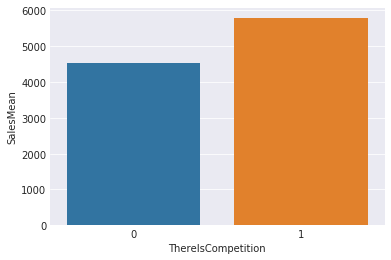

In [61]:
train['ThereIsCompetition'] = (~train['CompetitionDistance'].isna()).astype('int')
test['ThereIsCompetition'] = (~test['CompetitionDistance'].isna()).astype('int')
get_grouped_bar(['ThereIsCompetition'])

Очередное потверждение вреда наличия конкрентов объему оборота.

Если посмотреть на зависимость от расстояния на котором расположен конкурент, тоже можно увидеть тренд.

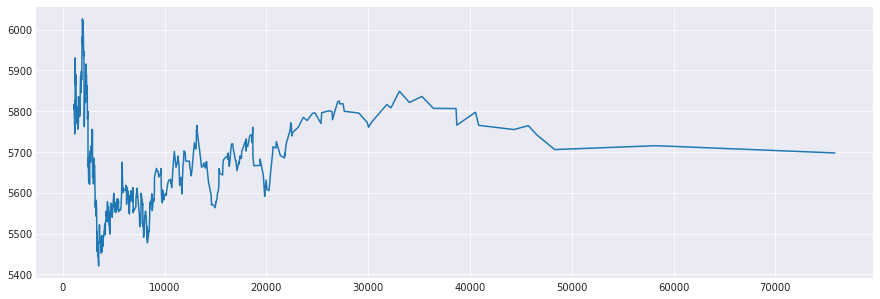

In [62]:
gr = train.groupby('CompetitionDistance')
xx = gr.groups.keys()
yy = gr['Sales'].mean()
yy_rolling = yy.rolling(window=100).mean()

plt.figure(figsize=(15, 5))
plt.plot(xx, yy_rolling);

In [63]:
non_nan = ~yy_rolling.isna()
np.argmin(yy_rolling[non_nan])

3510.0

Именно после этого значения начинается рост среднего, а до него идет падение.

### Выходные

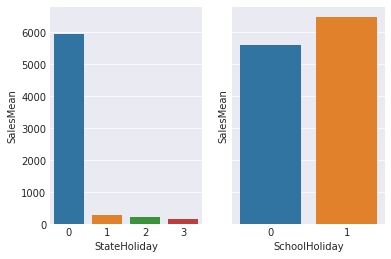

In [64]:
get_grouped_bar(['StateHoliday', 'SchoolHoliday'])

В то время как первый график вполне ожидаем, второй график говорит, что если магазин подвергся влиянию школьных выходных(каникул), то оборот должен быть выше. В голову приходит только подозрение, что такое поведение спровоцировано каникулами. А сколько именно каникул в этих данных?

Ответ на этот вопрос был выше при анализе данных. Их 166210. Стравнивая график ниже с графиком выше, становится понятно, что основное влияние оказывают именно каникулы.

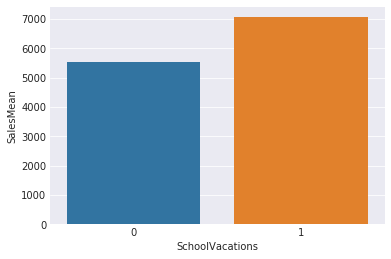

In [65]:
train['SchoolVacations'] = ((train['StateHoliday'] == 0) & (train['SchoolHoliday'] == 1)).astype('int')
test['SchoolVacations'] = ((test['StateHoliday'] == 0) & (test['SchoolHoliday'] == 1)).astype('int')
get_grouped_bar(['SchoolVacations'])

Заглядывая в будущее создадим и визуализируем признак "IsWeekend"(является ли день выходным).

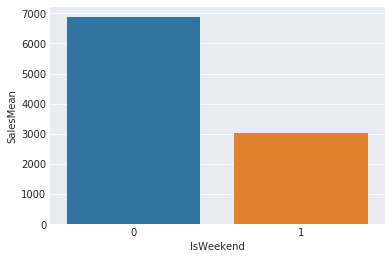

In [66]:
train['IsWeekend'] = (train['DayOfWeek'] > 5).astype('int')
test['IsWeekend'] = (test['DayOfWeek'] > 5).astype('int')
get_grouped_bar(['IsWeekend'])

Видно, что он сильно влияет на срднее по таргету.

### Ассортимент и вид магазина.

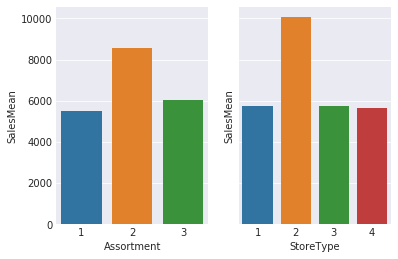

In [67]:
get_grouped_bar(['Assortment', 'StoreType'])

Похоже, что ассортимент часто привязан к типу магазина.

### Номер магазина
Чуть не забыли про то, что в данных ограниченное число магазинов, и поэтому есть смысл посмотреть на статистику по магазинам. Видно, что некоторые магазины показывают бОльшие значения оборота.

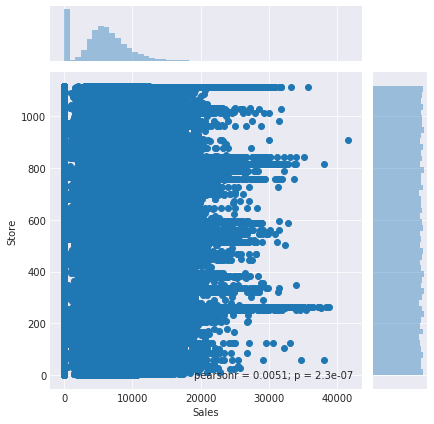

In [68]:
sns.jointplot('Sales', 'Store', data=train);

## Часть 4. Закономерности, "инсайты", особенности данных
Подытожим все, что было сказано выше.

### Закономерности:
* Одной из причин нулевого оборота является закрытость магазина(Признак Open).
* Из Assortment == 2 следует StoreType == 2
* Тип магазина 1 склонен иметь стандартный ассортимент, а тип магазина 3 склонен иметь расширенный ассортимент.
* Оборот и число клиентов сильно коррелируют.
* Но имеют большой разброс необычной формы. Стоит построить прямую и оценить разброс ошибки на различных ее интервалах.
* Магазины типа 2 работают всегда. Оттого и оборот они показывают больший.
* Остальные в большинстве своем отдыхают во время праздников.
* В данных есть тренд и сезоннсть. Линейная модель может неплохо восстановить тренд, а также сезоннсть при наличии подходящих признаков.
* Признак Promo равный 1 заметно повышает средний объем оборота.
* Конкуренты понижают оборот. Особенно те, что открылись не сильно давно и не слишком рано.
* Начиная с некоторой точки конкуренты поблизости понижают оборот. Виден восходящий тренд зависящий от растояния.
* До этой точки, наоборот, оборот экстремально высокий. Дело возможно в людности этих мест.
* Если смотреть на общую картину, выходные понижают объем оборота.
* Каникулы повышают оборот.
* Некоторые магазины показывают бОльшие объемы оборота.

### Трансформации признаков
* При использовании линейной модели таргет стоит прологарифмировать.

### Пропуски
Есть признаки с очень большим количеством пропусков:
* Promo2Since*, PromoInterval - 508031 пропусков. Природа: если магазин не участвует в Promo2, то и времени начала не существует.
* CompetitionDistance - 2642 пропусков. Природа: пропуск скорее всего значит отсутствие конкурентов.
* CompetitionSince* - 323348 пропусков. Природа: возможно просто некачественно собрали данные, возможно просто эти данные были неизвестны.

## Выбор метрики и модели

### Выбор метрики

In [69]:
desc = train[['Sales']].describe()
desc['Sales'] = desc['Sales'].values.astype('int')
desc

,Sales
count,1017209
mean,5773
std,3849
min,0
25%,3727
50%,5744
75%,7856
max,41551


In [70]:
np.sort(train['Sales'].values)[-10:]

array([37122, 37376, 37403, 37646, 38025, 38037, 38367, 38484, 38722,
       41551], dtype=int64)

Отбросим нулевые значения оборота.  
Большая часть наблюдений расположена рядом со средним значением, но есть и те записи, которые имеют очень высокие объемы оборота. Организаторы выбрали метрику Root Mean Square Percentage Error (RMSPE). Она допускает большие ошибки для объектов с большим абсолютным значением и сильнее штрафует за ошибки на объектах с меньшим абсолютным значением. Организаторы выбрали ее. Занчит именно она лучше всего подходила под задачи бизнеса.
Следовательно, оптимальным вариантом будет RMSPE. Его нужно будет минимизировать.

RMSPE можно записать так:
$$\sqrt{\frac{1}{n} \sum_{i=1}^{n} \Bigg( \frac{y_i - \hat{y}_i}{y_i} \Bigg )^2}$$, где $n$ - число объектов.

Если cловами, то мы смотрим на сколько процентов ошибаемся, возводим все ошибки в квадрат и суммируем, как в MSE, но потом еще и корень берем.

### Выбор модели

Решается задача регрессии. Учитывая наличие тренда и плохую способность "деревянных" моделей экстраполировать выбор падает на **линейные модели**. Они обучаются гораздо быстрее, имеют меньше гиперпараметров и легко справляются с большим числом признаков. А именно, будем использовать **линейную регрессию**. Стоит попробовать обычную и с lasso, ridge регуляризацией. 

## Часть 5. Предобработка данных

### Заполним пропуски

Первым делом выделим из датасета все наблюдения с закрытыми магазинами. Их предсказаниия мы знаем и строить по ним модель не имеет смысла. Метрику тоже будем считать без них, так как они все равно будут приносить в нее нулевой вклад.

In [71]:
closed_mask = train['Open'] == 0
closed_train = train[closed_mask]
train = train[~closed_mask]

In [72]:
closed_mask = test['Open'] == 0
closed_test = test[closed_mask]
zeros_test = test[closed_mask]
test = test[~closed_mask]

Конкурент где-то очень далеко - это то же самое, что его нет. Это соответствует тенденции, замеченной на одном из графиков выше. Заменим NaN значениями чуть болше максимума.

In [73]:
train['CompetitionDistance'].max(), test['CompetitionDistance'].max()

(75860.0, 75860.0)

In [74]:
train['CompetitionDistance'].fillna(75860. + 10000., inplace=True)
test['CompetitionDistance'].fillna(75860. + 10000., inplace=True)

Для признаков CompetitionOpenSince* подойдет среднее значение. Нули не будут иметь смысла, так как пользуемся мы линейной регрессией, а среднее будет этаким нейтральным вариантом при прогнозе. Других разумных вариантов не видно.Так же для TimeFromCompetitionBegin.

In [75]:
train['CompetitionOpenSinceMonth'].fillna(int(train['CompetitionOpenSinceMonth'].mean()), inplace=True)
train['CompetitionOpenSinceYear'].fillna(int(train['CompetitionOpenSinceYear'].mean()), inplace=True)
test['CompetitionOpenSinceMonth'].fillna(int(test['CompetitionOpenSinceMonth'].mean()), inplace=True)
test['CompetitionOpenSinceYear'].fillna(int(test['CompetitionOpenSinceYear'].mean()), inplace=True)
train['TimeFromCompetitionBegin'].fillna(int(train['TimeFromCompetitionBegin'].mean()), inplace=True)
test['TimeFromCompetitionBegin'].fillna(int(test['TimeFromCompetitionBegin'].mean()), inplace=True)

То же проделаем с признаками Promo2Since*.

In [76]:
train['Promo2SinceWeek'].fillna(int(train['Promo2SinceWeek'].mean()), inplace=True)
train['Promo2SinceYear'].fillna(int(train['Promo2SinceYear'].mean()), inplace=True)
test['Promo2SinceWeek'].fillna(int(test['Promo2SinceWeek'].mean()), inplace=True)
test['Promo2SinceYear'].fillna(int(test['Promo2SinceYear'].mean()), inplace=True)

Выделим таргет и выбросим признак Customers.

In [77]:
X, y = train.drop(['Sales', 'Customers'], axis=1), train['Sales']
y_t = np.log1p(y)
mean, std = y_t.mean(), y_t.std()
y_t = (y_t - mean) / std
del train

Cоздадим функции для вычисления метрик.

In [78]:
def rmspe(estimator, X, y):
    y_true = y
    y_pred = estimator.predict(X)
    
    m = ~(y_true == 0)
    return (np.sum(((y_true[m] - y_pred[m]) / y_true[m])**2) / y_true[m].shape[0])**0.5

def rmspe_log(estimator, X, y):
    """Возвращает rmspe score. Используется, если таргет прологарифмирован."""
    y_true = np.expm1(y * std + mean)
    y_pred = np.expm1(estimator.predict(X) * std + mean)
    
    m = ~(y_true < 1e-4)
    return (np.sum(((y_true[m] - y_pred[m]) / y_true[m])**2) / y_true[m].shape[0])**0.5

Зафиксируем деление выборки для кросс-валидации. Будем делить выборку на 4 части. Обучаться сначла на 1ой и предсказывать для второй. Потом обучаться на 1ой и 2ой, а предсказвать для 3ей и так далее, пока есть на чем предсказывать.

In [79]:
ts = TimeSeriesSplit(n_splits=3)

Создадим функцию для вычисления значения метрики на кросс-валидации. Использоваться будет Lasso регрессия. Обычная линейная регрессия не справляется, так как между признаками есть линейно зависимые. Их выбросим позже.

In [80]:
def get_score(X):
    """Проверяет точность Lasso регрессии на кросс-валидации предварительно отмасштабировав данные."""
    linreg_pipe = Pipeline([('scaler', StandardScaler()), ('linreg', Lasso(alpha=0.01))])
    return cross_val_score(linreg_pipe, X[X.columns[(X.dtypes == 'int64') | (X.dtypes == 'float64')]], 
                          y_t, scoring=rmspe_log, cv = ts, n_jobs=-1).mean()

Признаки будем добавлять только если они приносят пользу.

In [81]:
cur_score = get_score(X)
cur_score

0.45922473032423117

Способа, как визуализировать признак PromoInterval не нашлось, поэтому мы попробуем распарсить его, закодировать в виде 12 бинарных признаков каждый из которых значит свой месяц:
1. Если NaN, то везде будут нули.
2. Иначе единицы будут на тех месяцах, которые в этой строке встречались.

После, при отборе признаков, посмотрим полезный он или нет.

In [82]:
month_to_num = {
    'Jan': 0,
    'Feb': 1,
    'Mar': 2,
    'Apr': 3,
    'May': 4,
    'Jun': 5,
    'Jul': 6,
    'Aug': 7,
    'Sept': 8,
    'Oct': 9,
    'Nov': 10,
    'Dec': 11
}
num_to_month = dict(zip(month_to_num.values(), month_to_num.keys()))
X['PromoInterval'].unique()

array(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', nan],
      dtype=object)

In [83]:
not_na = ~X['PromoInterval'].isna()
temp = np.zeros((X[not_na].shape[0], 12), dtype='int')
for i, value in enumerate(X['PromoInterval'][not_na].apply(lambda x: x.split(','))):
    for mon in value:
        mon_num = month_to_num[mon]
        temp[i, mon_num] = 1
        
one_hot_months = np.zeros((X.shape[0], 12), dtype='int')
one_hot_months[not_na] = temp 
del temp
    
for i in range(12):
    mon = num_to_month[i]
    X["Promo2Renew" + mon] = one_hot_months[:, i]
del one_hot_months

In [84]:
new_score = get_score(X)
new_score

0.45835216296154474

Польза есть.

In [85]:
not_na = ~test['PromoInterval'].isna()
temp = np.zeros((test[not_na].shape[0], 12), dtype='int')
for i, value in enumerate(test['PromoInterval'][not_na].apply(lambda test: test.split(','))):
    for mon in value:
        mon_num = month_to_num[mon]
        temp[i, mon_num] = 1
        
one_hot_months = np.zeros((test.shape[0], 12), dtype='int')
one_hot_months[not_na] = temp 
del temp
    
for i in range(12):
    mon = num_to_month[i]
    test["Promo2Renew" + mon] = one_hot_months[:, i]
del one_hot_months

Переведем в dummy вид признаки, которые линейной регрессией иначе никак не интерпретируемы.

In [86]:
to_ohe_feats = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval', 'Store']
useful_feats = []
new_features = pd.DataFrame(index=X.index)
cur_score = get_score(X)
for feat in to_ohe_feats:
    dummies = pd.get_dummies(X[feat], prefix=feat)
    new_score = get_score(pd.concat([X, dummies], axis=1))
    if (new_score < cur_score):
        cur_score = new_score
        X = pd.concat([X, dummies], axis=1)
        print(feat, "is useful!")
        useful_feats.append(feat)
del dummies
X.drop(useful_feats, axis=1, inplace=True)

In [87]:
new_features = pd.DataFrame(index=test.index)
for feat in useful_feats:
    new_features = pd.concat([new_features, pd.get_dummies(test[feat], prefix=feat)], axis=1)
test = pd.concat([test, new_features], axis=1)
del new_features
test.drop(useful_feats, axis=1, inplace=True)

Здесь от OHE пользы не нашлось.  
Все не интовые и бесполезные в OHE виде признаки нужно выкинуть. Из даты тоже мы во время визуализации вытащили все нужные для работы далее признаки(день, месяц, год), поэтому теперь ее можно выбросить.

In [88]:
X = X[X.columns[(X.dtypes == 'int64') | (X.dtypes == 'float64')]]

Выделим таргет. Пользуемся линейной регрессией и поэтому прологарифмируем его. Нужно не забывать считать метрику с непрологарифмированным таргетом.

## Часть 6. Создание новых признаков и описание этого процесса

Очень много признаков были созданы вне этого раздела, но, все же есть, что добавить.  Признаки будем добавлять на основе наблюдений полученных выше.

Для начала это будут признаки отражающие сезонность. Мы поделим временную шкалу на части, в каждой из которых будем отсчитвать время с начала. 
Например, с 4 по 15 число таргет растет. создадим признак принимающий значения 1...12 для дней 4-15 и 0 для остальных.

In [89]:
new_score

0.45835216296154474

In [90]:
X['MonthlyTrendPart1'] = X['MonthDay'].apply(lambda x: x + 1 if (x <= 11) else 1 if (x == 31) else 0)
X['MonthlyTrendPart2'] = X['MonthDay'].apply(lambda x: x - 11 if (x > 11 and x<= 17) else 0)
X['MonthlyTrendPart3'] = X['MonthDay'].apply(lambda x: x - 17 if (x > 17 and x <= 24) else 0)
X['MonthlyTrendPart4'] = X['MonthDay'].apply(lambda x: x - 24 if (x > 24 and x <= 30) else 0)

In [91]:
new_score = get_score(X)
new_score

0.4553613843899997

Добавляем.

In [92]:
test['MonthlyTrendPart1'] = test['MonthDay'].apply(lambda test: test + 1 if (test <= 11) else 1 if (test == 31) else 0)
test['MonthlyTrendPart2'] = test['MonthDay'].apply(lambda test: test - 11 if (test > 11 and test<= 17) else 0)
test['MonthlyTrendPart3'] = test['MonthDay'].apply(lambda test: test - 17 if (test > 17 and test <= 24) else 0)
test['MonthlyTrendPart4'] = test['MonthDay'].apply(lambda test: test - 24 if (test > 24 and test <= 30) else 0)

В конце года оборот тоже растет. То же самое происходит в третий и седьмые месяцы.

In [93]:
good_months = [3, 7, 12]

for m in good_months:
    X['NearGoodMonth'+str(m)] = (X['YearMonth'].isin([m])).astype('int')
    test['NearGoodMonth'+str(m)] = (test['YearMonth'].isin([m])).astype('int')

In [94]:
new_score = get_score(X)
new_score

0.45315264403697997

Средние значения целевого признака были ниже на отрезке [-12; -3] значений признака _TimeFromCompetitionBegin_.

In [95]:
X['StrongCompetitorOld'] = X['TimeFromCompetitionBegin'].isin(range(-12, -2, 1)).astype('int')
test['StrongCompetitorOld'] = test['TimeFromCompetitionBegin'].isin(range(-12, -2, 1)).astype('int')

In [96]:
new_score = get_score(X)
new_score

0.45266937068158647

Тренд у признака _CompetitionDistance_ разный до значения 3510 и после. Поэтому создадим признак, позволяющий модели понять, на каком промежутке этого признака расположилось данное наблюдение.

In [97]:
X['AfterDistancePoint'] = (X['CompetitionDistance'] <= 3510).astype('int')
test['AfterDistancePoint'] = (test['CompetitionDistance'] <= 3510).astype('int')

In [98]:
new_score = get_score(X)
new_score

0.45267542787394827

Помнится второй магазин показывал более высокие средние значения таргета.

In [99]:
X['Is2ndType'] = (X['StoreType'] == 2).astype('int')
test['Is2ndType'] = (test['StoreType'] == 2).astype('int')

In [100]:
new_score = get_score(X)
new_score

0.4498164793706995

### Отбор признаков

Будем начиная с признака Year по-одному добавлять признаки в новую таблицу, если они приносят пользу(улучшают скор). Хотя это не гарантирует наилучший скор, такая эвристика имеет право на существование. Таким образом мы очень сильно уменьшим признаковое пространство.

In [101]:
get_score(X)

0.4498164793706995

In [102]:
new_X = pd.DataFrame(index=X.index)
new_X['Year'] = X['Year']
cur_score = get_score(new_X)
for feat in X.columns[(X.columns != 'Year')]:
    new_X[feat] = X[feat]
    new_score = get_score(new_X)
    if (new_score < cur_score):
        cur_score = new_score
        print(feat, 'is useful!')
    else:
        new_X.drop(feat, axis=1, inplace=True)

DayOfWeek is useful!
Promo is useful!
SchoolHoliday is useful!
StoreType is useful!
Assortment is useful!
CompetitionDistance is useful!
CompetitionOpenSinceMonth is useful!
CompetitionOpenSinceYear is useful!
Promo2SinceWeek is useful!
MonthDay is useful!
TimeFromCompetitionBegin is useful!
Promo2RenewMar is useful!
MonthlyTrendPart3 is useful!
MonthlyTrendPart4 is useful!
StrongCompetitorOld is useful!
Is2ndType is useful!


In [103]:
X = new_X
cur_score

0.4333624197397246

In [104]:
test = test[X.columns]

Процесс определенно имеет большую пользу!

## Часть 7. Кросс-валидация, подбор параметров

Поделим датасет на отложенную и тренировочную части. Важно: нельзя указывать _shuffle=True_, чтобы не было лика и валидация была корректной.

In [105]:
X_train, X_valid, y_train, y_valid = train_test_split(X.values, y_t.values, test_size=0.3)

Обучим обычную линейную регрессию.
Подберем на кросс-валидации параметры для _Lasso_ и _Ridge_ регрессий с помощью _LassoCV_ и _RidgeCV_. Подбирать параметры будем на данных X_train. Деление для кросс-валидации мы уже определили заранее, когда признаки добавляли.

### Прежний лучший результат
Это Lasso регрессия с параметром _alpha=0.01_.

In [106]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
rmspe_log(lasso, X_valid, y_valid)

0.44509383286353854

### Линейная регрессия
Подбирать тут нечего. Обучим и проверим точность на кроссвалидации. Для этого определим такую же фнкцию, какой до этого пользовались для Lasso регрессии. Запомним значение метрики.

In [107]:
def get_score(X, y):
    """Проверяет точность линейной регрессии на кросс-валидации предварительно отмасштабировав данные."""
    linreg_pipe = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
    return cross_val_score(linreg_pipe, X, 
                          y, scoring=rmspe_log, cv = ts, n_jobs=-1).mean()

In [108]:
get_score(X_train, y_train)

0.47164184754397115

### Lasso
Проведем кросс-валидацию. Параметр alpha будм подбирать на стандартном отрезке и 100 итерациях. В LassoCV нам не предоставлена возможность самим выбрать метрику, поэтому пользоваться будем стандартной. Не совсем корректно, учитвая также, что мы прологаримировали таргет, но вдруг это даст хороший скор в результате и для RMSPE. 

Здесь и далее используется масштабирование до подачи данных для кросс-валидации. Это не совсем корректно(среднее и отклонение утекает в тест), но на практике результаты мало отличаются.

In [109]:
lassoCV = LassoCV(cv=ts, n_jobs=-1, random_state=42, normalize=True) 
scaler = StandardScaler()
lassoCV.fit(scaler.fit_transform(X_train), y_train)

LassoCV(alphas=None, copy_X=True,
    cv=TimeSeriesSplit(max_train_size=None, n_splits=3), eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=-1,
    normalize=True, positive=False, precompute='auto', random_state=42,
    selection='cyclic', tol=0.0001, verbose=False)

In [110]:
lassoCV.alpha_

5.174426970897619e-07

In [111]:
rmspe_log(lassoCV, scaler.transform(X_valid), y_valid)

0.4428208988827886

Действительно лучше, чем раньше.

### Ridge

In [112]:
ridgeCV = RidgeCV(cv=ts, scoring=rmspe_log)
ridgeCV.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1.0, 10.0),
    cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
    fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=<function rmspe_log at 0x7fe15d887620>, store_cv_values=False)

In [113]:
ridgeCV.alpha_

0.1

In [114]:
rmspe_log(ridgeCV, X_valid, y_valid)

0.44270300236231425

Из-за масштаба признаков коэффицент регуляризации получился маленьким.

In [115]:
ridgeCV = RidgeCV(cv=ts, scoring=rmspe_log)
scaler = StandardScaler()
ridgeCV.fit(scaler.fit_transform(X_train), y_train)

RidgeCV(alphas=(0.1, 1.0, 10.0),
    cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
    fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=<function rmspe_log at 0x7fe15d887620>, store_cv_values=False)

In [116]:
ridgeCV.alpha_

10.0

In [117]:
rmspe_log(ridgeCV, scaler.transform(X_valid), y_valid)

0.4427034307328713

Тот же результат, но коэффицент другой. Принципиального улучшения в сравнении с Lasso не заметно, зато обе модели показали себя лучше, чем обычная линейная регрессия.

## Часть 8. Построение кривых валидации и обучения

### Валидационная кривая

Воспользуемся функцие для построения валидационных кривых из sklearn. Она проводит кросс-валидацию с каждым параметром и возвращает полученные значения метрики.

In [118]:
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso())])
alphas = np.linspace(1e-3, 1., 100)
val_train, val_test = validation_curve(lasso_pipe, X, y_t, param_name='lasso__alpha', 
                                       param_range=alphas, scoring=rmspe_log, cv=ts, n_jobs=-1) # не забываем, что таргет это y_t

In [119]:
def plot_with_error(x, scores, label):
    "Рисует кривые значений метрики в зависимости от параметра x при наличии результатов кросс валидации."
    mean_scores, std_scores = scores.mean(axis=1), scores.std(axis=1)
    plt.plot(x, mean_scores, label=label)
    plt.fill_between(x, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2)

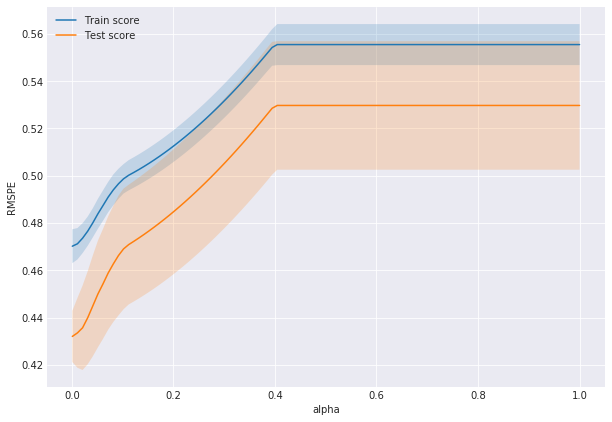

In [120]:
plt.figure(figsize=(10, 7))

plot_with_error(alphas, val_train, label="Train score")
plot_with_error(alphas, val_test, label="Test score")
plt.xlabel('alpha')
plt.ylabel('RMSPE')
plt.legend();

Явно видно, что до какого-то момента значение метрики ухудшается, а потом выходит на плато. Меньшие значения параметра регуляризации дают лучший скор. Это говорит о недообучении.

Очень странно то, что значения метрики на тесте всегда получаются ниже, но разброс сильно выше.

### Кривая обучения

Построим кривую обучения с коэффицентном регуляризации подобранном на кросс-валидации.

In [121]:
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.0005162441836497342))])
train_sizes = np.linspace(0.3, 1, 100)
num_train, val_train, val_test = learning_curve(lasso_pipe, X, y_t, 
                                                train_sizes=train_sizes, cv=ts, n_jobs=-1, scoring=rmspe_log)

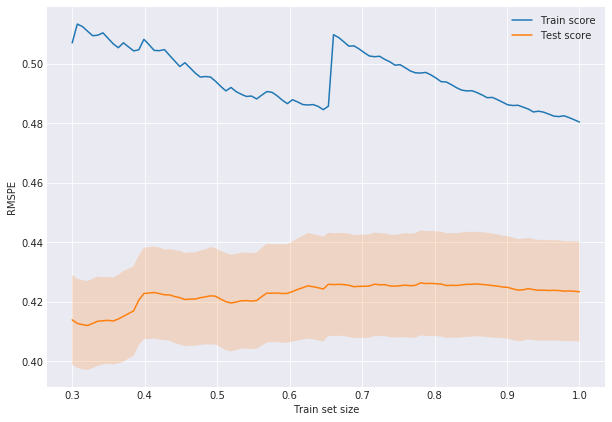

In [122]:
plt.figure(figsize=(10, 7))

plot_with_error(train_sizes, val_train, label="Train score")
plot_with_error(train_sizes, val_test, label="Test score")
plt.xlabel('Train set size')
plt.ylabel('RMSPE')
plt.legend();

Ситуация со значениями метрики на тесте очень похожа на валидационную кривую.   
Есть резкий скачок скора на трейне. Это может означать, что в это время появились новые, не похожие на ранее увиденные данные. 

Видно, что скор на трейне еще падает и не сошелся с тестом и поэтому дополнительные данные помогут.

## Часть 9. Прогноз для тестовой или отложенной выборки

Обучим Lasso(alpha=0.0005162441836497342) на всей выборке.

In [123]:
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.0005162441836497342))])
lasso_pipe.fit(X, y_t)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0005162441836497342, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [124]:
def write_to_submission_file(filename, prediction):
    """Записает предсказания в файл, как в примере."""
    sample = pd.read_csv('data/sample_submission.csv', index_col='Id')
    sample['Sales'] = prediction
    sample.to_csv('data/'+filename)

In [125]:
predictions = np.expm1(lasso_pipe.predict(test) * std + mean)
final_pred = np.zeros(closed_mask.shape[0])
final_pred[~closed_mask] = predictions

In [126]:
write_to_submission_file('lasso_submission.csv', final_pred)

In [127]:
!kaggle competitions submit -c rossmann-store-sales -f data/lasso_submission.csv -m "lasso regression"

Successfully submitted to Rossmann Store Sales

Private part составлен из 61% данных. Вот значения метрики на тестовом датасете.


<img src='../../img/leaderboard.png'>

## Часть 11. Выводы

Было найдено очень много зависимостей в данных, как и между признаками, так и с целевой переменной. Многие из признаков разработанных на их основе оказалсь полезными. Данная модель вряд ли может принести пользу бизнесу, так как предсказания имеют большой разброс, чего наоборот хотелось избежать.  

Несмотря на то, что основанно была выбрана линейная модель, оказалось, что она недостаточно мощная. Это исправить помогли некоторые из разработанных признаков. Стоит попробовать бустинг и нейронные сети, так как зависимость часто была нелинейной.
Также можно было сначала предсказать отдельной моделью число клиентов, для чего были данные, а уже потом объем оборота. Также стоит рассмотреть подход, когда для каждого магазина предасказания делаются отдельно.